<a href="https://colab.research.google.com/github/nofal82/nofal822/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
mkdir ~/.kaggle

In [12]:
cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! kaggle datasets download -d trolukovich/food11-image-dataset

 99% 1.08G/1.08G [00:05<00:00, 249MB/s]
100% 1.08G/1.08G [00:05<00:00, 199MB/s]


In [15]:
!unzip /content/food11-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/Soup/223.jpg   
  inflating: training/Soup/224.jpg   
  inflating: training/Soup/225.jpg   
  inflating: training/Soup/226.jpg   
  inflating: training/Soup/227.jpg   
  inflating: training/Soup/228.jpg   
  inflating: training/Soup/229.jpg   
  inflating: training/Soup/23.jpg    
  inflating: training/Soup/230.jpg   
  inflating: training/Soup/231.jpg   
  inflating: training/Soup/232.jpg   
  inflating: training/Soup/233.jpg   
  inflating: training/Soup/234.jpg   
  inflating: training/Soup/235.jpg   
  inflating: training/Soup/236.jpg   
  inflating: training/Soup/237.jpg   
  inflating: training/Soup/238.jpg   
  inflating: training/Soup/239.jpg   
  inflating: training/Soup/24.jpg    
  inflating: training/Soup/240.jpg   
  inflating: training/Soup/241.jpg   
  inflating: training/Soup/242.jpg   
  inflating: training/Soup/243.jpg   
  inflating: training/Soup/244.jpg   
  inflating: training/Soup/245.jpg   

In [17]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.7 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
# Import TensorFlow and other libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

<ipython-input-18-224081c327a5>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Define the model architecture
model = keras.Sequential([
# First convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape of (224, 224, 3)
layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
# Second convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
layers.Conv2D(64, 3, activation='relu'),
# First pooling layer with 2x2 pool size and stride of 2
layers.MaxPooling2D(2, strides=2),
# Third convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
layers.Conv2D(128, 3, activation='relu'),
# Second pooling layer with 2x2 pool size and stride of 2
layers.MaxPooling2D(2, strides=2),
# Flatten the output of the last pooling layer
layers.Flatten(),
# Fully connected layer with 256 units and ReLU activation
layers.Dense(256, activation='relu'),
# Dropout layer with dropout rate of 0.5
# layers.Dropout(0.5),
# Output layer with 11 units (one for each food category) and softmax activation
layers.Dense(11, activation='softmax')
])

In [ ]:
# Define the model architecture as a function that takes a hyperparameters object as an argument
def build_model(hp):
  model = keras.Sequential([
  # First convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape of (224, 224, 3)
  layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  # Second convolutional layer with a variable number of filters, 3x3 kernel size, and ReLU activation
  layers.Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), 3, activation='relu'),
  # First pooling layer with 2x2 pool size and stride of 2
  layers.MaxPooling2D(2, strides=2),
  # Third convolutional layer with a variable number of filters, 3x3 kernel size, and ReLU activation
  layers.Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), 3, activation='relu'),
  # Second pooling layer with 2x2 pool size and stride of 2
  layers.MaxPooling2D(2, strides=2),
  # Flatten the output of the last pooling layer
  layers.Flatten(),
  # Fully connected layer with a variable number of units and ReLU activation
  layers.Dense(hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'),
  # Dropout layer with a variable dropout rate
  layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
  # Output layer with 11 units (one for each food category) and softmax activation
  layers.Dense(11, activation='softmax')
  ])
  # Compile the model with a variable learning rate and Adam optimizer
  model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
  metrics=['accuracy']
  )

  return model

In [ ]:
# Load the data from the training/validation/evaluation folders
train_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='/content/training',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)

Found 9866 files belonging to 11 classes.


In [ ]:
# Define the data augmentation layer
augment_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1)

# Apply the data augmentation layer to the training data
train_data = train_data.map(lambda x, y: (augment_layer(x), y))


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='/content/validation',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)

Found 3430 files belonging to 11 classes.


In [ ]:
eval_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='/content/evaluation',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)

Found 3347 files belonging to 11 classes.


In [ ]:
# Resize and normalize the images
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
rescale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (resize_layer(x), y))
train_data = train_data.map(lambda x, y: (rescale_layer(x), y))

val_data = val_data.map(lambda x, y: (resize_layer(x), y))
val_data = val_data.map(lambda x, y: (rescale_layer(x), y))

eval_data = eval_data.map(lambda x, y: (resize_layer(x), y))
eval_data = eval_data.map(lambda x, y: (rescale_layer(x), y))

In [ ]:
# Compile the model
model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

In [ ]:
# Train the model
model.fit(
train_data,
validation_data=val_data,
epochs=10,
batch_size=32
)

Epoch 1/10
309/309 [==============================] - 233s 662ms/step - loss: 2.7293 - accuracy: 0.1486 - val_loss: 2.2845 - val_accuracy: 0.1458
Epoch 2/10
309/309 [==============================] - 194s 624ms/step - loss: 2.2401 - accuracy: 0.1956 - val_loss: 2.1882 - val_accuracy: 0.2289
Epoch 3/10
309/309 [==============================] - 193s 622ms/step - loss: 2.1717 - accuracy: 0.2282 - val_loss: 2.1400 - val_accuracy: 0.2350
Epoch 4/10
309/309 [==============================] - 193s 621ms/step - loss: 2.1452 - accuracy: 0.2352 - val_loss: 2.0999 - val_accuracy: 0.2411
Epoch 5/10
309/309 [==============================] - 195s 628ms/step - loss: 2.1127 - accuracy: 0.2513 - val_loss: 2.0681 - val_accuracy: 0.2534
Epoch 6/10
309/309 [==============================] - 195s 629ms/step - loss: 2.0671 - accuracy: 0.2631 - val_loss: 2.0131 - val_accuracy: 0.2802
Epoch 7/10
309/309 [==============================] - 194s 623ms/step - loss: 2.0071 - accuracy: 0.2861 - val_loss: 2.0291 -

In [ ]:
# Evaluate the model
model.evaluate(eval_data)

In [ ]:
# Define the random search tuner with the model function, the objective metric, and the maximum number of trials
tuner = RandomSearch(
build_model,
objective='val_accuracy',
max_trials=10
)

In [ ]:
# Search for the best hyperparameters by training different models on the training and validation data
tuner.search(
train_data,
validation_data=val_data,
epochs=10,
batch_size=32
)

Trial 10 Complete [00h 19m 11s]
val_accuracy: 0.5198251008987427

Best val_accuracy So Far: 0.524781346321106
Total elapsed time: 02h 35m 54s


### trying pre-trained Model

In [ ]:
# Load the pre-trained model (ResNet50) without the top layer
base_model = keras.applications.ResNet50(
weights='imagenet',
input_shape=(224, 224, 3),
include_top=False
)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Freeze the base model
base_model.trainable = False

In [ ]:
# Define the model architecture with the base model and a new top layer
model = keras.Sequential([
# Use the base model as the first layer
base_model,
# Add a global average pooling layer to reduce the feature map size
layers.GlobalAveragePooling2D(),
# Add a fully connected layer with 256 units and ReLU activation
layers.Dense(256, activation='relu'),
# Add a dropout layer with dropout rate of 0.2
layers.Dropout(0.2),
# Add an output layer with 11 units (one for each food category) and softmax activation
layers.Dense(11, activation='softmax')
])


In [ ]:
# Load the data from the training/validation/evaluation folders
train_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='training',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='validation',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)

eval_data = tf.keras.preprocessing.image_dataset_from_directory(
directory='evaluation',
labels='inferred',
label_mode='categorical',
image_size=(224, 224),
batch_size=32
)


Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [10]:
# Resize and normalize the images
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
rescale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (resize_layer(x), y))
train_data = train_data.map(lambda x, y: (rescale_layer(x), y))

val_data = val_data.map(lambda x, y: (resize_layer(x), y))
val_data = val_data.map(lambda x, y: (rescale_layer(x), y))

eval_data = eval_data.map(lambda x, y: (resize_layer(x), y))
eval_data = eval_data.map(lambda x, y: (rescale_layer(x), y))

# Define the data augmentation layer
augment_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1)

# Apply the data augmentation layer to the training data
train_data = train_data.map(lambda x, y: (augment_layer(x), y))

NameError: ignored

In [ ]:
# Compile the model
model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

In [ ]:
# Train the model
model.fit(
train_data,
validation_data=val_data,
epochs=10,
batch_size=32
)

Epoch 1/10
309/309 [==============================] - 82s 249ms/step - loss: 2.2686 - accuracy: 0.1865 - val_loss: 2.1940 - val_accuracy: 0.2242
Epoch 2/10
309/309 [==============================] - 77s 247ms/step - loss: 2.2042 - accuracy: 0.2160 - val_loss: 2.1567 - val_accuracy: 0.2242
Epoch 3/10
309/309 [==============================] - 78s 251ms/step - loss: 2.1847 - accuracy: 0.2284 - val_loss: 2.1419 - val_accuracy: 0.2242
Epoch 4/10
309/309 [==============================] - 77s 247ms/step - loss: 2.1702 - accuracy: 0.2252 - val_loss: 2.1425 - val_accuracy: 0.2402
Epoch 5/10
309/309 [==============================] - 77s 247ms/step - loss: 2.1617 - accuracy: 0.2297 - val_loss: 2.1453 - val_accuracy: 0.2321
Epoch 6/10
309/309 [==============================] - 86s 275ms/step - loss: 2.1542 - accuracy: 0.2366 - val_loss: 2.1175 - val_accuracy: 0.2472
Epoch 7/10
309/309 [==============================] - 86s 276ms/step - loss: 2.1355 - accuracy: 0.2437 - val_loss: 2.1073 - val_ac

## trying new way

In [22]:

# Import tensorflow and other libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

In [23]:
# Define the class names and labels
class_names = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles-Pasta", "Rice", "Seafood", "Soup", "Vegetable-Fruit"]
num_classes = len(class_names)


In [24]:
# Define the image size and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create a data generator that rescales the images and applies data augmentation
data_gen = keras.preprocessing.image.ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True
)

In [25]:
# Load the training data from the training folder
train_data = data_gen.flow_from_directory(
directory="training",
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode="categorical",
shuffle=True
)
# Load the validation data from the validation folder
val_data = data_gen.flow_from_directory(
directory="validation",
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode="categorical",
shuffle=False
)

# Load the evaluation data from the evaluation folder
eval_data = data_gen.flow_from_directory(
directory="evaluation",
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode="categorical",
shuffle=False
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [26]:
# Create a CNN model using keras Sequential API
model = keras.Sequential([
# Convolutional layer with 32 filters, 3x3 kernel size, ReLU activation and input shape
layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
# Max pooling layer with 2x2 pool size
layers.MaxPooling2D((2, 2)),
# Convolutional layer with 64 filters, 3x3 kernel size and ReLU activation
layers.Conv2D(64, (3, 3), activation="relu"),
# Max pooling layer with 2x2 pool size
layers.MaxPooling2D((2, 2)),
# Convolutional layer with 128 filters, 3x3 kernel size and ReLU activation
layers.Conv2D(128, (3, 3), activation="relu"),
# Max pooling layer with 2x2 pool size
layers.MaxPooling2D((2, 2)),
# Flatten layer to convert the feature maps into a 1D vector
layers.Flatten(),
# Dense layer with 256 units and ReLU activation
layers.Dense(256, activation="relu"),
# Dropout layer with 0.5 rate to reduce overfitting
# layers.Dropout(0.1),
# Output layer with num_classes units and softmax activation for multi-class classification
layers.Dense(num_classes, activation="softmax")
])

In [27]:
# Compile the model with categorical crossentropy loss, Adam optimizer and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0003), metrics=["accuracy"])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

In [28]:
# Train the model for 10 epochs using train_data and val_data
model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
309/309 [==============================] - 208s 667ms/step - loss: 2.2291 - accuracy: 0.2208 - val_loss: 1.9978 - val_accuracy: 0.2895
Epoch 2/10
309/309 [==============================] - 205s 664ms/step - loss: 1.9582 - accuracy: 0.3088 - val_loss: 1.8769 - val_accuracy: 0.3399
Epoch 3/10
309/309 [==============================] - 202s 655ms/step - loss: 1.8378 - accuracy: 0.3560 - val_loss: 1.7713 - val_accuracy: 0.3805
Epoch 4/10
309/309 [==============================] - 202s 654ms/step - loss: 1.7464 - accuracy: 0.3887 - val_loss: 1.7126 - val_accuracy: 0.4128
Epoch 5/10
309/309 [==============================] - 204s 662ms/step - loss: 1.6539 - accuracy: 0.4243 - val_loss: 1.7073 - val_accuracy: 0.4134
Epoch 6/10
309/309 [==============================] - 204s 660ms/step - loss: 1.5887 - accuracy: 0.4428 - val_loss: 1.5652 - val_accuracy: 0.4598
Epoch 7/10
309/309 [==============================] - 205s 664ms/step - loss: 1.5212 - accuracy: 0.4735 - val_loss: 1.5013 -

In [ ]:
# Evaluate the model on eval_data and print the loss and accuracy
loss, acc = model.evaluate(eval_data)
print(f"Loss: {loss}, Accuracy: {acc}")

## Trying transfer learning with InceptionResNetV2-imagenet model

---




In [19]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Load the pretrained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

219055592/219055592 [==============================] - 1s 0us/step


In [4]:
# Freeze the base model
base_model.trainable = False

In [20]:
# Add a global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [21]:
# Add a dense layer with 11 units and softmax activation for classification
output = tf.keras.layers.Dense(11, activation='softmax')(x)

In [22]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Create an image data generator for image augmentation
datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

In [25]:
# Create a training generator from the training folder
train_generator = datagen.flow_from_directory(
'training',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=True
)

# Create a validation generator from the validation folder
validation_generator = datagen.flow_from_directory(
'validation',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

# Create a evaluation generator from the evaluation folder
evaluation_generator = datagen.flow_from_directory(
'evaluation',
target_size=(224, 224),
batch_size=32,
class_mode='categorical',
shuffle=False
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [26]:
# Train the model for 10 epochs
history = model.fit(train_generator, epochs=8, validation_data=validation_generator)

Epoch 1/8
309/309 [==============================] - 260s 776ms/step - loss: 0.9272 - accuracy: 0.6923 - val_loss: 0.7003 - val_accuracy: 0.7697
Epoch 2/8
309/309 [==============================] - 226s 731ms/step - loss: 0.6624 - accuracy: 0.7792 - val_loss: 0.6722 - val_accuracy: 0.7720
Epoch 3/8
309/309 [==============================] - 223s 724ms/step - loss: 0.6184 - accuracy: 0.7921 - val_loss: 0.6296 - val_accuracy: 0.7933
Epoch 4/8
309/309 [==============================] - 223s 723ms/step - loss: 0.5660 - accuracy: 0.8091 - val_loss: 0.6505 - val_accuracy: 0.7933
Epoch 5/8
309/309 [==============================] - 223s 722ms/step - loss: 0.5467 - accuracy: 0.8157 - val_loss: 0.6176 - val_accuracy: 0.7962
Epoch 6/8
309/309 [==============================] - 221s 715ms/step - loss: 0.5275 - accuracy: 0.8189 - val_loss: 0.6619 - val_accuracy: 0.7813
Epoch 7/8
309/309 [==============================] - 222s 719ms/step - loss: 0.5261 - accuracy: 0.8272 - val_loss: 0.6441 - val_ac

In [29]:
history.history


{'loss': [0.927182674407959,
  0.6623834371566772,
  0.6184028387069702,
  0.5660414695739746,
  0.5466780066490173,
  0.5274998545646667,
  0.5260702967643738,
  0.52028888463974],
 'accuracy': [0.6922764778137207,
  0.7792418599128723,
  0.7921143174171448,
  0.809142529964447,
  0.8157308101654053,
  0.81887286901474,
  0.82718425989151,
  0.8267788290977478],
 'val_loss': [0.7003103494644165,
  0.6721848249435425,
  0.6296314001083374,
  0.6505197882652283,
  0.6176443099975586,
  0.6618556380271912,
  0.6440631747245789,
  0.5860305428504944],
 'val_accuracy': [0.7696793079376221,
  0.7720116376876831,
  0.7932944893836975,
  0.7932944893836975,
  0.7962099313735962,
  0.7813411355018616,
  0.7932944893836975,
  0.8093294501304626]}

In [30]:
from keras.models import load_model

model.save('food_11_v3.h5')  # creates a HDF5 file 'my_model.h5'

#model = load_model('food_11_v1.h5')

In [31]:
# Evaluate the model on the evaluation data using `evaluate`
print("Evaluate on evaluation data")
results = model.evaluate(evaluation_generator)
print("evaluation loss, evaluation acc:", results)

Evaluate on evaluation data
105/105 [==============================] - 63s 600ms/step - loss: 0.5113 - accuracy: 0.8261
evaluation loss, evaluation acc: [0.5113394856452942, 0.8261129260063171]


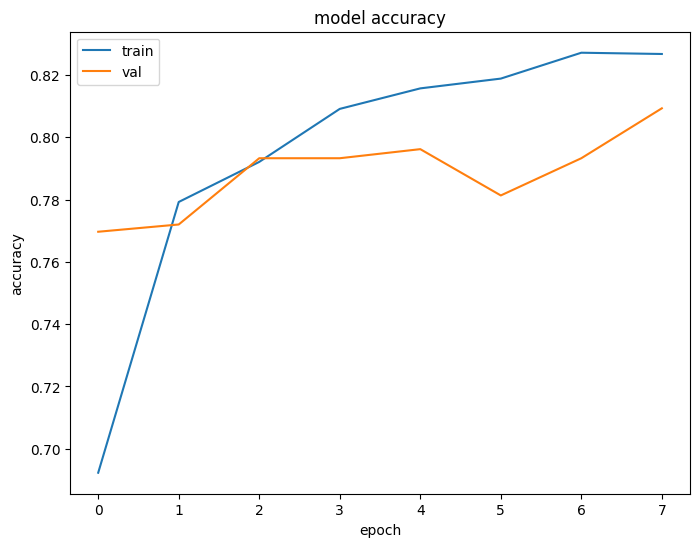

In [33]:
# Import libraries for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

105/105 [==============================] - 65s 583ms/step


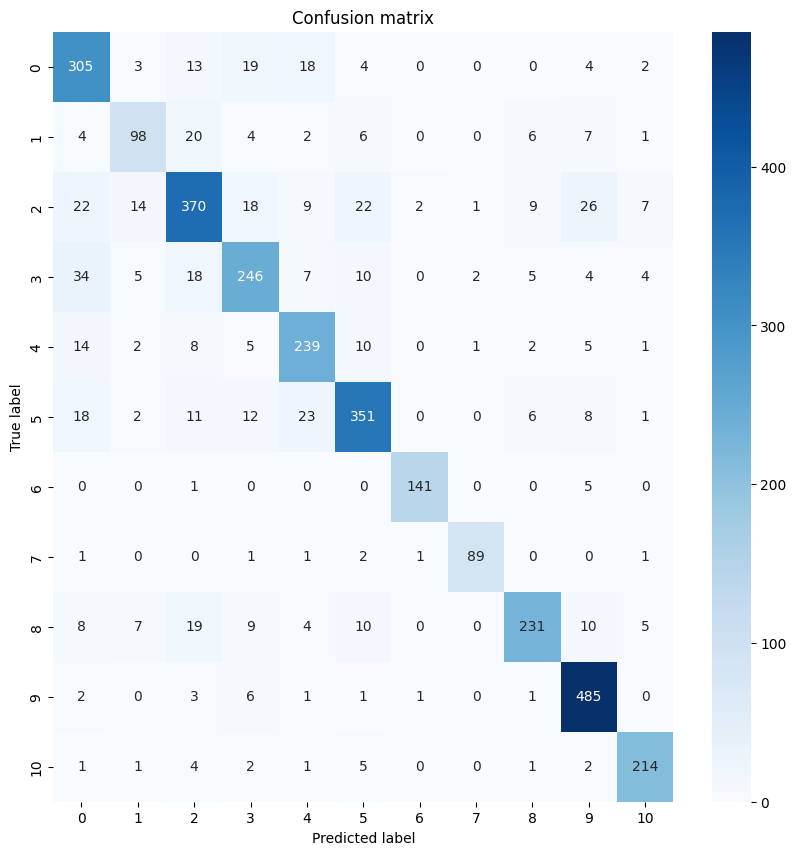

In [41]:
# Get the true and predicted labels from the evaluation data
y_true = evaluation_generator.classes
#y_pred = model.predict_classes(evaluation_generator)
y_pred = model.predict(evaluation_generator)
x=np.argmax(y_pred,axis=1)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_true, x)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()